## Jacobians and Gain matrix at a typical state to assess sensitivities



> First, we need to import some packages in Julia

In [27]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI
using  CairoMakie, Interpolations
using InstrumentOperator, Unitful, Interpolations, DiffResults, NCDatasets, LinearAlgebra, ForwardDiff, Printf
include(joinpath(dirname(pathof(CarbonI)), "Requirements", "common.jl"))

  Activating project at `~/code/gitHub/CarbonI`


setup_data (generic function with 1 method)

In [3]:
scenario = CarbonI.reference_scenario() 
specs = CarbonI.build_instrument("CBE")
#specs = CarbonI.build_instrument("Requirement")

# Create an instrument with the specs
ins = InstrumentOperator.createGratingNoiseModel(specs.ET, specs.Pitch, 
	specs.FPA_quantum_efficiency, specs.bench_efficiency, 
	specs.Fnumber, 2*specs.SSI, 
	(specs.readout_noise), specs.dark_current); 

soil, x, solarIrr, σ_matrix, profile, h, Sₐ = setup_data(scenario, specs)
sza = 40.0 # Solar zenith angle in degrees

(ds["T"])[iLon, iLat, :, timeIndex] = Union{Missing, Float32}[187.60953, 195.1012, 201.35501, 208.64655, 216.49673, 222.47076, 227.39767, 230.89746, 235.26309, 242.40393, 250.36801, 259.4926, 268.20334, 272.86224, 273.1006, 270.50668, 266.17313, 261.9602, 257.33777, 253.24066, 249.31465, 244.15125, 240.6859, 238.05463, 235.39015, 231.98767, 228.57484, 226.37009, 223.45546, 222.34386, 220.49219, 217.9867, 216.47473, 214.98712, 213.25296, 210.32483, 207.75937, 206.41586, 207.52103, 209.51251, 210.57042, 216.20634, 224.16565, 232.26859, 240.40128, 247.10199, 252.58617, 255.18288, 257.9303, 263.41864, 267.52917, 272.1396, 276.66675, 280.92175, 284.42505, 286.95496, 289.00113, 290.2957, 290.15128, 289.2277, 289.0184, 290.03265, 291.2717, 292.5702, 293.89865, 295.23, 296.56677, 297.8983, 299.22983, 300.5767, 301.94052, 303.46246]


40.0

In [17]:
refl = soil(specs.modelling_wl)
# Run Forward model and Jacobian generation together:
result = DiffResults.JacobianResult(zeros(length(specs.instrument_wl)),x);

ForwardDiff.jacobian!(result, (x) -> 
forward_model_x_(x, 
				sun=solarIrr, 
				instrument=specs.instrument_kernel,
				reflectance=refl, 
				sza=sza, 
				σ_matrix=σ_matrix, 
				profile=profile,
				wl=specs.modelling_wl), x);
K = DiffResults.jacobian(result);
F = DiffResults.value(result);  

# Compute noise equivalent radiance:
nesr = InstrumentOperator.noise_equivalent_radiance(ins,(specs.instrument_wl)u"nm", (F)u"mW/m^2/nm/sr");
nesr_ = nesr./1u"mW/m^2/nm/sr"

# Generate S\_epsilon matrix
Se = Diagonal(nesr_.^2);

# Compute the Gain Matrix:
G = inv(K'inv(Se)K + inv(Sₐ))K'inv(Se);

# Posterior covariance matrix (Profile retrievals, 10 layers):
Ŝ = inv(K'inv(Se)K + inv(Sₐ));

In [5]:
iHDO = findall(h["hdo"].>0)[end];


In [6]:
iH2O = findall(h["h2o"].>0)[end]

20

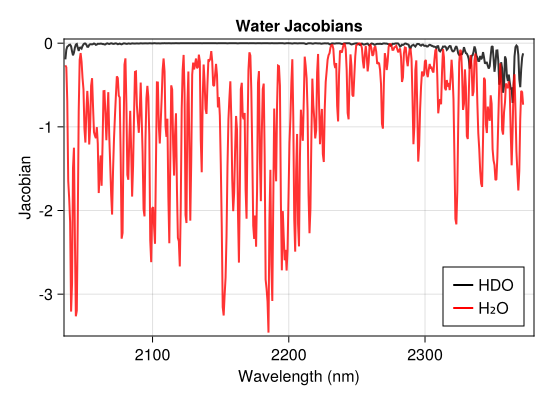

In [7]:
f = Figure(resolution=(550,400), backgroundcolor=:transparent)
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Jacobian", title="Water Jacobians")
# For CH4 (100 and 120e-)
al = 0.8
hdo = lines!(ax, specs.instrument_wl, K[:,iHDO], color=:black, linewidth=2, label="HDO", alpha=al)
h2o = lines!(ax, specs.instrument_wl, K[:,iH2O], color=:red, linewidth=2, label="H₂O", alpha=al)

xlims!(ax,2035,2380)
ylims!(ax,-3.5,0.05)
axislegend(ax,position = :rb)
save("../../plots/final/WaterJacobians.pdf",f)
f

In [35]:
# Test a forward model error, using an additive offset as simple example
δy = ones(length(specs.instrument_wl)) .* 0.002; # Additive offset

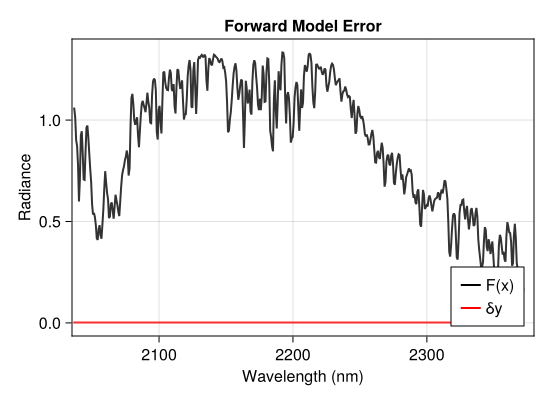

In [36]:
f = Figure(resolution=(550,400), backgroundcolor=:transparent)
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Radiance", title="Forward Model Error")
# For CH4 (100 and 120e-)
al = 0.8
Fx = lines!(ax, specs.instrument_wl, F, color=:black, linewidth=2, label="F(x)", alpha=al)
dy = lines!(ax, specs.instrument_wl, δy, color=:red, linewidth=2, label="δy", alpha=al)

xlims!(ax,2035,2380)
#ylims!(ax,-3.5,0.05)
axislegend(ax,position = :rb)
#save("../../plots/final/WaterJacobians.pdf",f)
f

In [37]:
δx = G * δy; # Jacobian times the error


In [40]:
# Relative Impact on CO2:
xco2 = h["co2"]' * x;
δxco2 = h["co2"]' * δx;
@show "Relative impact on CO2:",  (δxco2/xco2) * 100

xch4 = h["ch4"]' * x;
δxch4 = h["ch4"]' * δx;
@show "Relative impact on CH4:",  (δxch4/xch4) * 100

xn2o = h["n2o"]' * x;
δn2o = h["n2o"]' * δx;
@show "Relative impact on N2O:",  (δn2o/xn2o) * 100

xh2o = h["h2o"]' * x;
δh2o = h["h2o"]' * δx;
@show "Relative impact on H2O:",  (δh2o/xh2o) * 100


("Relative impact on CO2:", (δxco2 / xco2) * 100) = ("Relative impact on CO2:", -0.29097018212684833)
("Relative impact on CH4:", (δxch4 / xch4) * 100) = ("Relative impact on CH4:", -0.44689710279698186)
("Relative impact on N2O:", (δn2o / xn2o) * 100) = ("Relative impact on N2O:", -0.6488419541476448)
("Relative impact on H2O:", (δh2o / xh2o) * 100) = ("Relative impact on H2O:", -0.4088933759108225)


("Relative impact on H2O:", -0.4088933759108225)